## **0. Introduction**

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_train.name = 'Training Set'
df_test = pd.read_csv('../input/test.csv')
df_test.name = 'Test Set'

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}'.format(df_train['target'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 200000
Number of Test Examples = 200000
Training X Shape = (200000, 202)
Training y Shape = 200000
Test X Shape = (200000, 201)
Test y Shape = 200000
Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


## **1. Exploratory Data Analysis**

### **1.1 Overview**
* Both training set and test set have **200000** rows
* Training set have **202** features and test set have **201** features
* One extra feature in the training set is `target` feature, which is the class of a row
* `target` feature is binary (**0** or **1**), **1 = transaction** and **0 = no transaction**
* `ID_code` feature is the unique id of the row and it doesn't have any effect on target
* The other features are anonymized and labeled from `var_0` to `var_199`
* There are no missing values in both training set and test set because the dataset is already processed

In [3]:
print(df_train.info())
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


ID_code  target    var_0   var_1    var_2   var_3    var_4  \
180310  train_180310       0   7.2372 -0.3929  10.7813  8.3299  10.3933   
135442  train_135442       0   8.9150 -0.5565  12.0905  7.1139  10.6573   
56010    train_56010       0   8.3043 -0.4238  10.0439  8.0226   9.3761   
139709  train_139709       0   9.0067  1.9019   7.7803  9.4357  11.8247   
46403    train_46403       0  10.4402 -0.5977   7.8748  5.7883  11.4365   

          var_5   var_6    var_7   var_8   var_9  var_10   var_11   var_12  \
180310  -1.0656  3.9385  15.4054 -2.4868  7.7747 -0.7670  -1.1692  14.0942   
135442 -16.6981  3.7403  20.6148  2.5346  7.4482  5.0422   2.2913  14.1998   
56010   -7.9246  4.4251   9.7233  0.1057  7.7721 -8.5635  -2.6883  14.0747   
139709   8.1326  5.0507  10.7529  1.4934  9.1509 -7.6368   7.2655  13.9042   
46403  -11.2739  6.5673  10.0361 -0.5749  8.1492 -0.5241 -11.4372  13.8455   

        var_13  var_14   var_15   var_16   var_17   var_18   var_19   var_20  \
180310  0.8387  5.5064  14.9536   7.4947   5.5111  12.5512  -5.0774  21.1431   
135442  2.8256  5.6234  14.5167   8.7412 -10.6958  16.3594  21.6723  10.3338   
56010   9.1405  4.0084  14.5158  11.9860  -7.0612  22.1162   2.9523   7.4539   
139709  9.9935  9.5031  14.8874  15.9719 -11.2514   8.4628  21.5303  12.6508   
46403   4.7771  4.8692  15.1428  10.6664  -8.4600   7.0660   7.2637  19.5368   

         var_21  var_22  var_23   var_24   var_25  var_26  var_27  var_28  \
180310   3.7817  7.4971  2.1658   4.9273  13.8181 -7.3448 -0.2111  5.0431   
135442  11.3734 -0.1477  2.3888   4.1183  13.7349  7.1282 -1.0092  6.0699   
56010   32.9514  0.0293  3.2442  13.1632  13.5015 -5.8343 -0.8212  5.7625   
139709   7.7595  5.3698  2.3410   5.7589  14.2753 -0.2765 -2.4481  5.8297   
46403   18.8162 -1.0618  2.7434   8.7864  13.5308 -7.1366  0.1334  4.6451   

        var_29   var_30   var_31  var_32   var_33   var_34   var_35  var_36  \
180310  0.8402   1.2444  10.6584 -4.5670  16.1168  11.8756   5.4902  6.1558   
135442  6.8269  -2.6545  14.4154 -5.0505  14.3978  12.0679  -0.0984  0.3189   
56010   4.1201 -14.5602   7.9305  0.9847  12.4205  11.5600  14.3207  1.0827   
139709  8.3049 -12.8636  10.4939 -5.5366  11.0634  11.8408  -4.7705  1.9597   
46403   9.6669  -7.5250   8.6357  3.3608  12.4573  11.1873   4.7301  6.9598   

        var_37   var_38  var_39   var_40   var_41   var_42   var_43   var_44  \
180310  1.8164  10.4520  6.9085  12.5396  10.1910  10.8773  11.2794  12.3049   
135442  6.8557   9.0060  3.8964 -18.8689  11.8560  11.1176  12.1048  11.3777   
56010   7.3172   4.3242  1.8717 -16.3729  18.8858  10.9716  11.2800  13.6535   
139709  3.5480   6.6039  6.6680 -25.2260   2.3420  12.3426  11.5683   9.4954   
46403   3.7965   7.5915 -6.8167 -10.4253  10.5003  11.0135  11.1841  21.2018   

         var_45   var_46   var_47   var_48   var_49   var_50   var_51  var_52  \
180310 -23.0952   5.9363   1.2686  26.5652  33.5853  12.5302  14.3722 -3.5471   
135442  -4.4931  14.4785   6.5831  11.1967   1.4373  12.4153   6.2502  2.1269   
56010    7.5497  13.4218 -11.7726  -0.0144  22.9548  12.9320   8.4175 -8.0745   
139709  11.4784  17.3302 -27.9956  16.9935   9.2587  12.7805  21.2435 -7.9830   
46403   17.7852   8.8055 -14.6006  -0.4159  12.3152  12.2760  15.5676 -0.2177   

        var_53  var_54   var_55   var_56  var_57  var_58   var_59   var_60  \
180310  5.4046 -0.9705   6.1724  15.0293  6.4110  1.9651   9.2134  12.0664   
135442  5.8569 -6.2885  14.8501  11.9689  5.6964 -1.4388   9.1172  14.6216   
56010   5.8594 -3.8798   5.9541  15.4847  7.6958  0.8994   9.1794  11.9345   
139709  4.9031 -8.6155  12.0500  17.5001  6.6027  9.5688  10.7135  19.2267   
46403   6.4380  4.9161   6.7219  19.9561  5.2891 -4.5075   9.1247  15.2471   

         var_61  var_62  var_63  var_64  var_65  var_66   var_67  var_68  \
180310  -1.6564  1.3414  5.3309  8.8697  2.3631  6.1593  24.5668  5.0184   
135442 -10.1464  0.2832 -1.8739  5.0953 -0.5216  6.0001   0.2745  5.0199   
56010  -2

In [4]:
print(df_test.info())
df_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


ID_code    var_0   var_1    var_2   var_3    var_4    var_5  \
24794    test_24794   7.9284  3.9444   7.6602  7.8052  10.6134   6.4663   
121400  test_121400   7.1256 -7.7172  12.7091  9.3035  11.1095  -3.7189   
156311  test_156311  16.0613  2.1105  11.2933  8.7220  12.1362 -18.4877   
4462      test_4462   8.7867  1.3022  14.6271  3.9824  13.2316  -3.0436   
39579    test_39579  11.4966 -0.7151  10.6889  6.8716   8.4167  -3.1820   

         var_6    var_7   var_8   var_9  var_10   var_11   var_12   var_13  \
24794   5.6519   9.6420 -2.7179  8.2278  3.8696   3.8075  13.9878   8.7416   
121400  6.6552  13.8790  4.7438  8.8968  4.5589  -5.7740  14.2188   8.5629   
156311  6.4547  13.7560  1.8582  8.9628  4.4953  -2.5358  14.0487  10.4127   
4462    4.9606  12.3024  3.4879  5.6913 -3.1233 -12.4386  14.0409  15.9707   
39579   4.6647  16.6887 -2.4357  9.5707  4.9079   6.5998  13.8534   3.2108   

         var_14   var_15   var_16   var_17   var_18   var_19   var_20  \
24794    8.5466  14.2719   7.9855 -17.3135  25.4568  10.1497   8.4512   
121400  10.0251  14.3183  11.3362  -8.5562  10.2465   3.6059   9.3801   
156311  10.2839  14.3711  12.0920   3.6758  18.1880  24.3729   7.0492   
4462     7.0272  14.4286   7.9763  -7.8230   0.8774   2.6354  15.6071   
39579    8.3489  14.5346   6.9796  -8.3743  27.7429   6.1007   9.4446   

         var_21  var_22  var_23   var_24   var_25   var_26  var_27  var_28  \
24794   29.5104  2.5157  2.6160   7.4666  13.2703  -4.9550 -0.2790  5.5592   
121400  19.0216  2.0734  2.7471   9.1556  13.3135  -8.5593  0.0805  4.7897   
156311  29.6956  7.7579  3.0569   9.8272  13.6309 -12.7676 -3.2329  5.0445   
4462    29.1208  1.3813  3.1858  11.2989  13.4898 -10.9064 -3.5195  5.0053   
39579    1.9804  5.5855  3.0908  15.0393  13.9042  -7.8227  0.0392  5.4066   

        var_29   var_30   var_31  var_32   var_33   var_34   var_35  var_36  \
24794   3.3079  -5.4248  10.6281  2.1252  12.3448  11.3379   1.2417  5.3952   
121400  2.5162  -3.3002   9.2762  5.0617  20.9280  11.8371   9.4706  2.8908   
156311  4.2961 -13.4332  12.3429 -4.3403  17.1216  11.3695   5.1146  1.8042   
4462    2.9299 -13.9548   8.7059 -4.9987   9.4203  11.6587  -0.6792  2.1672   
39579   7.8525  -6.2318  10.4759 -3.4020  15.5146  11.4371  12.7737  1.8948   

        var_37   var_38  var_39   var_40   var_41   var_42   var_43   var_44  \
24794   7.2337  15.0463  6.1152  -7.2110  14.2782  10.9510  11.6576   6.8207   
121400  4.2712   5.8352  4.0399 -12.6800  18.2126  11.0411  11.5019  15.9295   
156311  4.2116   5.1921  1.1300 -11.4474  24.1406  11.1648  11.5081   6.0647   
4462    8.7878   8.4421 -0.1910  -3.4991  16.7739  11.3086  11.4568  13.2645   
39579   8.4675  16.8476 -2.2140  -7.7857   3.3571  11.7690  11.1195  -3.3063   

         var_45   var_46   var_47   var_48   var_49   var_50   var_51  var_52  \
24794   16.0269  12.3054   1.9726  16.0404  15.0179  12.0141   1.8050 -1.0385   
121400  24.7327  14.5128 -14.7979   2.3641  12.3549  11.6642  18.3210 -4.1776   
156311  21.3888  12.6204 -23.8954 -12.5286   8.7006  13.4208  20.0922 -0.2906   
4462     1.9442  10.5984 -27.3845  26.7301  23.8611  14.1293  10.1163 -6.6806   
39579    8.8820  12.9083  -3.3099  18.3867  20.2144  11.1658  14.3203  3.2690   

        var_53   var_54   var_55   var_56  var_57   var_58  var_59   var_60  \
24794   5.5714 -24.6918  16.7177  18.1042  6.3623   2.3195  9.3859   3.7957   
121400  5.2256  12.9313  18.6050  14.7379  5.7748   0.8755  9.0985   8.9230   
156311  6.1183  -0.9447  16.5083  15.9741  5.3174   3.5905  9.5000  10.9526   
4462    6.5933  12.0477  17.5682  16.0775  4.9742   3.9122  9.4641  13.3552   
39579   5.0932   6.8151  21.6887  19.2287  5.8815  13.6876  7.8640  12.0429   

         var_61  var_62  var_63  var_64  var_65  var_66   var_67  var_68  \
24794   -2.5756  3.7126 -1.0921  5.0527  6.5638  5.3048   8.5723  5.0023   
121400 -16.1366 -2.6958  1.1769  7.2314  6.5374  5.8342   2.6525  5.0230   
156311  -2.3509  4.0359  2.6520  7.116

### **1.2 Target Distribution**
* **10.05%** (20098/200000) of the training set is **Class 1**
* **89.95%** (179902/200000) of the training set is **Class 0**

20098 out of 200000 rows are Class 1 and it is the 10.05% of the dataset.
179902 out of 200000 rows are Class 0 and it is the 89.95% of the dataset.


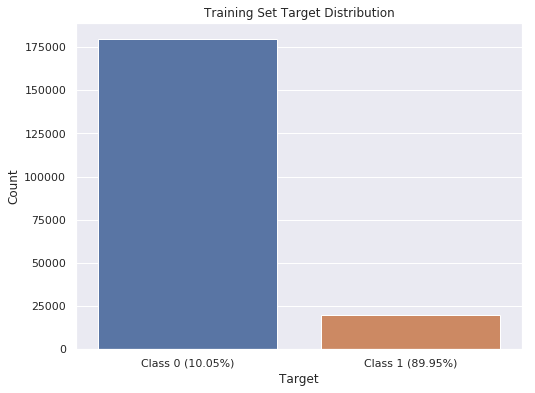

In [5]:
ones = df_train['target'].value_counts()[1]
zeros = df_train['target'].value_counts()[0]
ones_per = ones / df_train.shape[0] * 100
zeros_per = zeros / df_train.shape[0] * 100

print('{} out of {} rows are Class 1 and it is the {:.2f}% of the dataset.'.format(ones, df_train.shape[0], ones_per))
print('{} out of {} rows are Class 0 and it is the {:.2f}% of the dataset.'.format(zeros, df_train.shape[0], zeros_per))

plt.figure(figsize=(8, 6))
sns.countplot(df_train['target'])

plt.xlabel('Target')
plt.xticks((0, 1), ['Class 0 ({0:.2f}%)'.format(ones_per), 'Class 1 ({0:.2f}%)'.format(zeros_per)])
plt.ylabel('Count')
plt.title('Training Set Target Distribution')

plt.show()

### **1.3 Correlations**
Features from `var_0` to `var_199` have extremely low correlation between each other in both training set and test set. The lowest correlation between variables is **2.7e-8** and it is in the training set (between `var_191` and `var_75`). The highest correlation between variables is **0.00986** and it is in the test set (between `var_139` and `var_75`). `target` has slightly higher correlations with other features. The highest correlation between a feature and `target` is **0.08** (between `var_81` and `target`).

In [6]:
df_train_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [7]:
# Top 5 Highest Correlations in the Training Set
df_train_corr_nd.tail()

Feature 1 Feature 2  Correlation Coefficient
40190   var_110    target                 0.064275
40192     var_6    target                 0.066731
40194    var_12    target                 0.069489
40196    target   var_139                 0.074080
40198    target    var_81                 0.080917

In [8]:
# Top 5 Highest Correlations between variables in the Training Set
df_train_corr_nd[np.logical_and(df_train_corr_nd['Feature 1'] != 'target', df_train_corr_nd['Feature 2'] != 'target')].tail()

Feature 1 Feature 2  Correlation Coefficient
39868   var_183   var_189                 0.009359
39870    var_81   var_174                 0.009490
39872   var_165    var_81                 0.009714
39874    var_53   var_148                 0.009788
39876   var_139    var_26                 0.009844

In [9]:
# Top 5 Highest Correlations in the Test Set
df_test_corr_nd.tail()

Feature 1 Feature 2  Correlation Coefficient
39790   var_122   var_164                 0.008513
39792   var_164     var_2                 0.008614
39794    var_31   var_132                 0.008714
39796    var_96   var_143                 0.008829
39798   var_139    var_75                 0.009868

### **1.4 Unique Value Count**
The lowest unique value count belongs to `var_68` which has only **451** unique values in training set and **428** unique values in test set. **451** and **428** unique values in **200000** rows are too less that `var_68` could even be a categorical feature. The highest unique value count belongs to`var_45` which has **169968** unique values in the training set and **92058** unique values in the test set. Every feature in training set have higher unique value counts compared to features in test set.

The lowest unique value count difference is in the `var_68` feature (Training Set Unique Count **451**, Test Set Unique Count **428**). The highest unique value count difference is in the `var_45` feature (Training Set Unique Count **169968**, Test Set Unique Count **92058**). When the unique value count of a feature increases, the difference between training set unique value count and test set unique value count also increases. The explanation of this situation is probably the synthetic records in the test set. 

In [10]:
df_train_unique = df_train.agg(['nunique']).transpose().sort_values(by='nunique')
df_test_unique = df_test.agg(['nunique']).transpose().sort_values(by='nunique')
df_uniques = df_train_unique.drop('target').reset_index().merge(df_test_unique.reset_index(), how='left', right_index=True, left_index=True)
df_uniques.drop(columns=['index_y'], inplace=True)
df_uniques.columns = ['Feature', 'Training Set Unique Count', 'Test Set Unique Count']

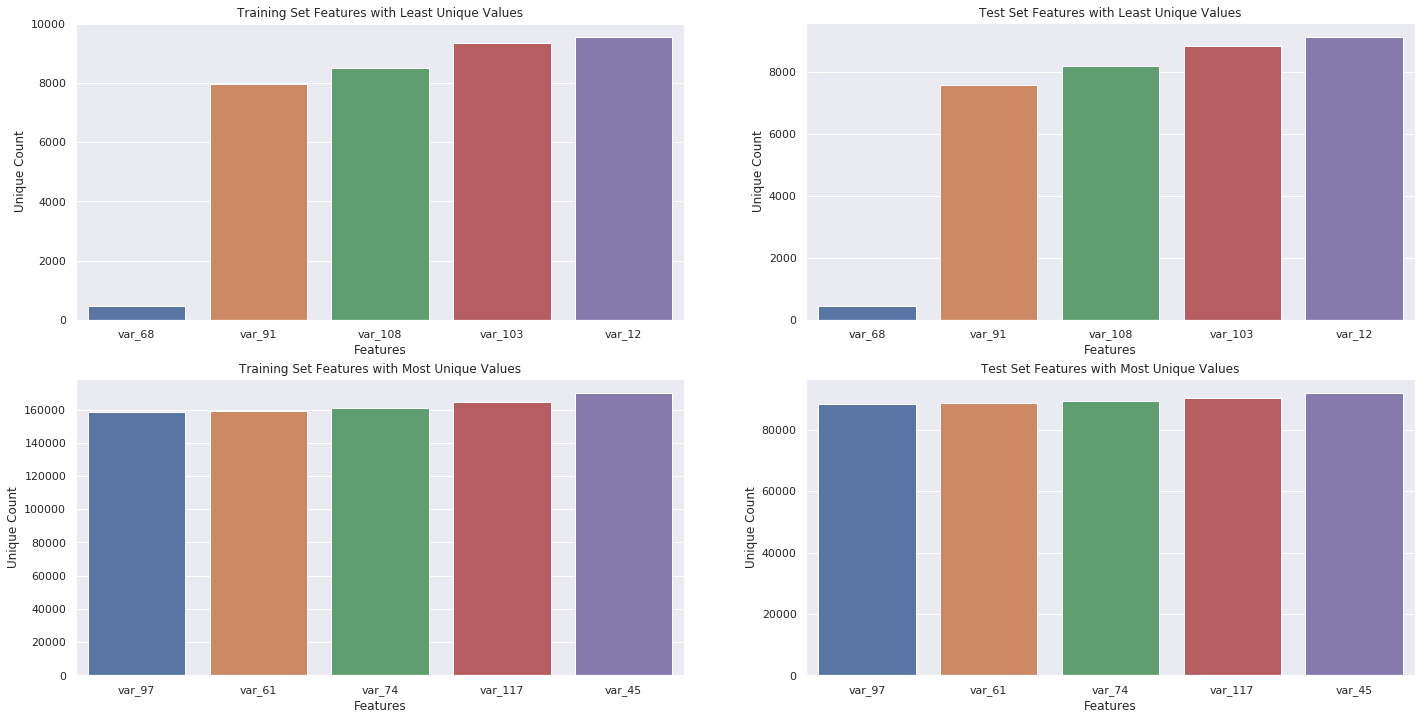

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 12))

sns.barplot(x=df_train_unique.index[1:6], y="nunique", data=df_train_unique[1:].head(), ax=axs[0][0])
sns.barplot(x=df_test_unique.index[:5], y="nunique", data=df_test_unique.head(), ax=axs[0][1])
sns.barplot(x=df_train_unique.index[-6:-1], y="nunique", data=df_train_unique[-6:-1].tail(), ax=axs[1][0])
sns.barplot(x=df_test_unique.index[-6:-1], y="nunique", data=df_test_unique[-6:-1].tail(), ax=axs[1][1])

for i in range(2):
    for j in range(2):        
        axs[i][j].set(xlabel='Features', ylabel='Unique Count')
        
axs[0][0].set_title('Training Set Features with Least Unique Values')
axs[0][1].set_title('Test Set Features with Least Unique Values')
axs[1][0].set_title('Training Set Features with Most Unique Values')
axs[1][1].set_title('Test Set Features with Most Unique Values')

plt.show()

### **1.5 Target Distribution in Quartiles**
Class 1 `target` distribution in feature quartiles are quite similar for each feature. Most of the class 1 `target` rows are either in the **1st** quartile or in the **4th** quartile of the features because of the winsorization. Winsorization clips the extreme values, so they are grouped up in the spikes inside **1st** quartile and **4th** quartile.
* **94** features have highest class 1 `target` percentage in **1st** quartile
* **101** features have highest class 1 `target` percentage in **4th** quartile
* Only **5** features have highest class 1 `target` percetange in **2nd** and **3rd** quartile, and those features are `var_17`, `var_30`, `var_100`, `var_101`, `var_105`

Maximum class 1 `target` percentage for **1st** quartile is **14.35%** (**85.65%** class 0), and for **4th** quartile is **13.43%** (**86.57%** class 0). Maximum class 1 `target` percentage for **2nd** quartile is **10.34%** (**89.66%** class 0), and for **3rd** quartile is **10.05%** (**89.95%** class 0 `target`). To conclude, values in **1st** and **4th** quartiles have higher chance (**3-4%**) to be class 1 than values in **2nd** and **3rd** quartile for 195 features.

In [12]:
df_qdist = pd.DataFrame(np.zeros((200, 9)), columns=['Quartile 1 Positives', 'Quartile 2 Positives', 'Quartile 3 Positives', 'Quartile 4 Positives',
                                                     'Quartile 1 Positive Percentage', 'Quartile 2 Positive Percentage', 'Quartile 3 Positive Percentage', 'Quartile 4 Positive Percentage',
                                                     'Quartile Order'])
features = [col for col in df_train.columns.values.tolist() if col.startswith('var')]
quartiles = np.arange(0, 1, 0.25)
df_qdist.index = features

for i, feature in enumerate(features):
    for j, quartile in enumerate(quartiles):
        target_counts = df_train[np.logical_and(df_train[feature] >= df_train[feature].quantile(q=quartile), 
                                                df_train[feature] < df_train[feature].quantile(q=quartile + 0.25))].target.value_counts()
        
        ones_per = target_counts[1] / (target_counts[0] + target_counts[1]) * 100
        df_qdist.iloc[i, j] = target_counts[1]
        df_qdist.iloc[i, j + 4] = ones_per

pers = df_qdist.columns.tolist()[4:-1]         
        
for i, index in enumerate(df_qdist.index):
    order = df_qdist[pers].iloc[[i]].sort_values(by=index, ascending=False, axis=1).columns
    order_str = ''.join([col[9] for col in order])
    df_qdist.iloc[i, 8] = order_str        
                
df_qdist = df_qdist.round(2)
df_qdist.head(10)

Quartile 1 Positives  Quartile 2 Positives  Quartile 3 Positives  \
var_0                4518.0                4472.0                4725.0   
var_1                4325.0                4641.0                5093.0   
var_2                4449.0                4432.0                4926.0   
var_3                4850.0                4930.0                5105.0   
var_4                4931.0                4937.0                4931.0   
var_5                4601.0                4819.0                5011.0   
var_6                4244.0                4288.0                5036.0   
var_7                5140.0                4980.0                5060.0   
var_8                4630.0                5043.0                5034.0   
var_9                5775.0                5088.0                4902.0   

       Quartile 4 Positives  Quartile 1 Positive Percentage  \
var_0                6383.0                            9.04   
var_1                6039.0                            8.65   
var_2                6291.0                            8.90   
var_3                5213.0                            9.70   
var_4                5299.0                            9.86   
var_5                5667.0                            9.20   
var_6                6530.0                            8.49   
var_7                4918.0                           10.28   
var_8                5391.0                            9.26   
var_9                4333.0                           11.55   

       Quartile 2 Positive Percentage  Quartile 3 Positive Percentage  \
var_0                            8.94                            9.45   
var_1                            9.28                           10.19   
var_2                            8.86                            9.85   
var_3                            9.86                           10.21   
var_4                            9.87                            9.86   
var_5                            9.64                           10.02   
var_6                            8.58                           10.07   
var_7                            9.96                           10.12   
var_8                           10.09                           10.07   
var_9                           10.18                            9.80   

       Quartile 4 Positive Percentage Quartile Order  
var_0                           12.77           4312  
var_1                           12.08           4321  
var_2                           12.58           4312  
var_3                           10.43           4321  
var_4                           10.60           4213  
var_5                           11.33           4321  
var_6                           13.06           4321  
var_7                            9.84           1324  
var_8                           10.78           4231  
var_9                            8.67           1234

In [13]:
# 5 features that doesn't have highest positive target percentage in 1st and 4th quartiles
df_qdist[np.logical_or(df_qdist['Quartile Order'].str.startswith('2'), df_qdist['Quartile Order'].str.startswith('3'))] 

Quartile 1 Positives  Quartile 2 Positives  Quartile 3 Positives  \
var_17                 4996.0                5025.0                5067.0   
var_30                 4982.0                5059.0                5006.0   
var_100                4946.0                5104.0                5008.0   
var_101                5164.0                5171.0                4836.0   
var_185                5025.0                5006.0                5083.0   

         Quartile 4 Positives  Quartile 1 Positive Percentage  \
var_17                 5010.0                            9.99   
var_30                 5051.0                            9.96   
var_100                5040.0                            9.89   
var_101                4927.0                           10.33   
var_185                4983.0                           10.05   

         Quartile 2 Positive Percentage  Quartile 3 Positive Percentage  \
var_17                            10.05                           10.13   
var_30                            10.12                           10.01   
var_100                           10.21                           10.02   
var_101                           10.34                            9.67   
var_185                           10.01                           10.17   

         Quartile 4 Positive Percentage Quartile Order  
var_17                            10.02           3241  
var_30                            10.10           2431  
var_100                           10.08           2431  
var_101                            9.85           2143  
var_185                            9.97           3124

In [14]:
for i, col in enumerate(pers):    
    print('There are {} features that have the highest positive target percentage in Quartile {}'.format(df_qdist[df_qdist['Quartile Order'].str.startswith(str(i + 1))].count()[0],
                                                                                                            i + 1))
    print('Quartile {} max positive target percentage = {}% ({})'.format(i + 1, df_qdist[col].max(), df_qdist[col].argmax()))
    print('Quartile {} min positive target percentage = {}% ({})\n'.format(i + 1, df_qdist[col].min(), df_qdist[col].argmin()))

There are 94 features that have the highest positive target percentage in Quartile 1
Quartile 1 max positive target percentage = 14.35% (var_81)
Quartile 1 min positive target percentage = 8.49% (var_6)

There are 3 features that have the highest positive target percentage in Quartile 2
Quartile 2 max positive target percentage = 10.68% (var_149)
Quartile 2 min positive target percentage = 8.58% (var_6)

There are 2 features that have the highest positive target percentage in Quartile 3
Quartile 3 max positive target percentage = 10.46% (var_184)
Quartile 3 min positive target percentage = 8.4% (var_81)

There are 101 features that have the highest positive target percentage in Quartile 4
Quartile 4 max positive target percentage = 13.43% (var_110)
Quartile 4 min positive target percentage = 8.32% (var_34)



### **1.6 Feature Distributions in Training and Test Set**
Training and test set distributions of features are not perfectly identical. There are bumps on the distribution peaks of test set because the unique value counts are lesser than training set. Distribution tails are smoother than peaks and spikes are present in both training and test set.

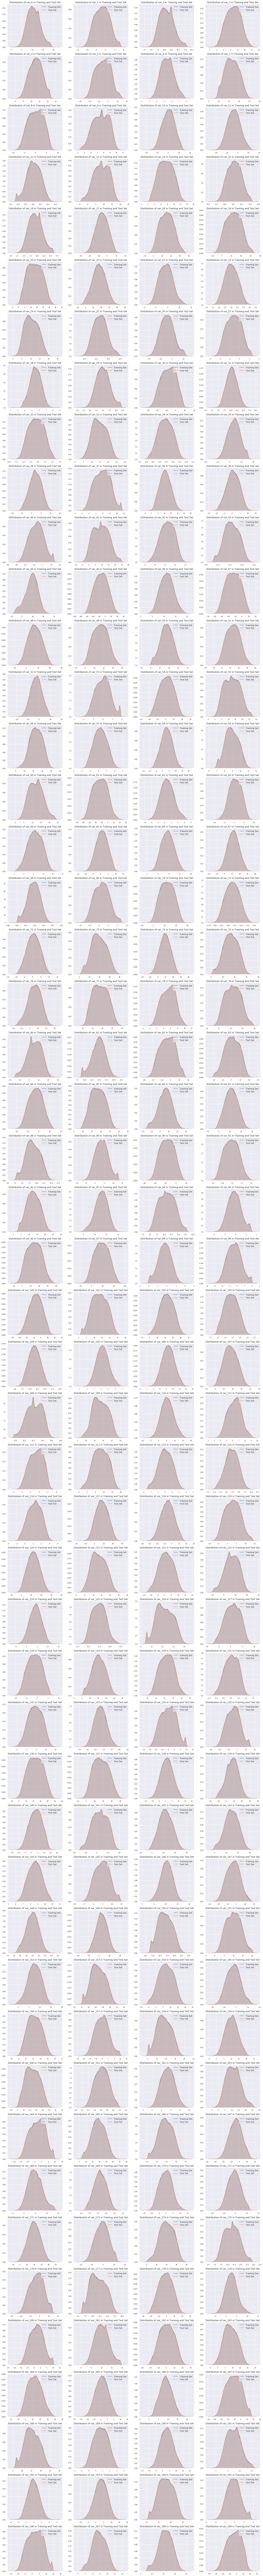

In [15]:
features = [col for col in df_train.columns.tolist() if col.startswith('var')]

nrows = 50
fig, axs = plt.subplots(nrows=50, ncols=4, figsize=(24, nrows * 5))

for i, feature in enumerate(features, 1):
    plt.subplot(50, 4, i)
    sns.kdeplot(df_train[feature], bw='silverman', label='Training Set', shade=True)
    sns.kdeplot(df_test[feature], bw='silverman', label='Test Set', shade=True)
    
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.legend(loc='upper right')
    plt.title('Distribution of {} in Training and Test Set'.format(feature))
    
plt.show()

### **1.7 Target Distributions in Features**
Majority of the features have good split points and huge spikes. This explains why a simple LightGBM model can achieve 0.90 AUC. Distribution difference is bigger in tails because of winsorization.

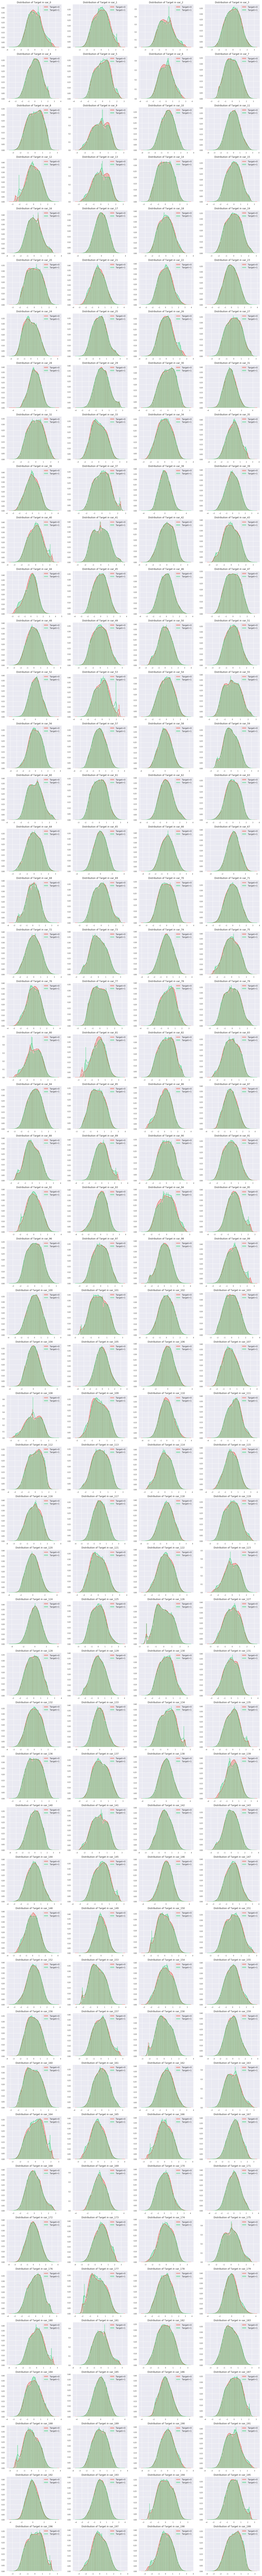

In [16]:
features = [col for col in df_train.columns.tolist() if col.startswith('var')]

nrows = 50
fig, axs = plt.subplots(nrows=50, ncols=4, figsize=(24, nrows * 5))

for i, feature in enumerate(features, 1):
    plt.subplot(50, 4, i)
    
    sns.distplot(StandardScaler().fit_transform(df_train[df_train['target'] == 0][feature].values.reshape(-1, 1)), label='Target=0', hist=True, color='#e74c3c')
    sns.distplot(StandardScaler().fit_transform(df_train[df_train['target'] == 1][feature].values.reshape(-1, 1)), label='Target=1', hist=True, color='#2ecc71')
    
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.legend(loc='upper right')
    plt.xlabel('')
    plt.title('Distribution of Target in {}'.format(feature))
    
plt.show()

### **1.8 Conclusion**
Data imbalance is very common in customer datasets like this. Oversampling **Class 1** or undersampling **Class 0** are suitable solutions for this dataset because of its large size. Since the dataset is big enough, resampling would not introduce underfitting.

Training set has more unique values than test set so some part of test set is most likely synthetic. Rows with more frequent values are less reliable because test set has bumps over distribution peaks. This is also related to synthetic data in test set.

Features are not correlated with each other or not dependent to each other. However, `target` feature has the highest correlation with `var_81` (**0.08**). This relationship can bu used to make other features more informative. If a feature is target encoded on `var_81`, it could give information about `target`.

Values in **1st** and **4th** quartiles have higher chance to be **Class 1** than values in **2nd** and **3rd** quartile for almost every feature because of winsorization.

## **2. Feature Engineering and Data Augmentation**

### **2.1 Separating Real/Synthetic Test Data and Magic Features**
Using unique value count in a row to identify synthetic samples. If a row has at least one unique value in a feature, then it is real, otherwise it is synthetic. This technique is shared by [YaG320](https://www.kaggle.com/yag320) in this kernel [List of Fake Samples and Public/Private LB split](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split) and it successfuly identifies synthetic samples in entire test set. This way the unusual bumps on the distribution peaks of test set features are captured. The magic features are extracted from the combination of training set and real samples in the test set. 

In [17]:
test = df_test.drop(['ID_code'], axis=1).values

unique_count = np.zeros_like(test)

for feature in range(test.shape[1]):
    _, index, count = np.unique(test[:, feature], return_counts=True, return_index=True)
    unique_count[index[count == 1], feature] += 1
    
real_samples = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synth_samples = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Number of real samples in test set is {}'.format(len(real_samples)))
print('Number of synthetic samples in test set is {}'.format(len(synth_samples)))

Number of real samples in test set is 100000
Number of synthetic samples in test set is 100000


In [18]:
features = [col for col in df_train.columns if col.startswith('var')]
df_all = pd.concat([df_train, df_test.ix[real_samples]])

for feature in features:
    temp = df_all[feature].value_counts(dropna=True)

    df_train[feature + 'vc'] = df_train[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)
    df_test[feature + 'vc'] = df_test[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)

    df_train[feature + 'sum'] = ((df_train[feature] - df_all[feature].mean()) * df_train[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32)
    df_test[feature + 'sum'] = ((df_test[feature] - df_all[feature].mean()) * df_test[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32) 

    df_train[feature + 'sum2'] = ((df_train[feature]) * df_train[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)
    df_test[feature + 'sum2'] = ((df_test[feature]) * df_test[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)

    df_train[feature + 'sum3'] = ((df_train[feature]) * df_train[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32) 
    df_test[feature + 'sum3'] = ((df_test[feature]) * df_test[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32)
    
print('Training set shape after creating magic features: {}'.format(df_train.shape))
print('Test set shape after creating magic features: {}'.format(df_test.shape))

Training set shape after creating magic features: (200000, 1002)
Test set shape after creating magic features: (200000, 1001)


### **2.2 Data Augmentation**
Oversampling the data increases CV and LB score significantly since the data is imbalanced. This oversampling technique is shared by [Jiwei Liu](https://www.kaggle.com/jiweiliu) in this kernel [LGB 2 leaves + augment](https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment).

In [19]:
def augment(x, y, t=2):
    
    xs, xn = [], []
    
    for i in range(t // 2):
        mask = y == 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1

        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(featnum)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(featnum)]]
        xn.append(x1)
    
    for i in range(t):
        mask = y > 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1
        
        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(1)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(1)]]
        xs.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xs, xn])
    y = np.concatenate([y, ys, yn])
    
    return x, y

### **2.3 Quartile Rank (Not Used)**
This code ranks every value by their quartile. Ranking is done according to the features' **Class 1** distribution percentage in a quartile. In order to do that, every features' quartiles are sorted by **Class 1** percentage. After that, the ranks **(4, 3, 2, 1)** are mapped to the sorted quartiles. This way, the quartile with the highest **Class 1** distribution in a feature gets the highest rank. After every value in a row are ranked,the ranks are summed and scaled. This way the mean rank of a row is calculated. The problems with this feature are:
* The distributions are already captured by decision trees, so this feature is not very useful in LightGBM
* If this feature is computed outside the folds, it leaks data

In [20]:
"""
def get_quartile_mask(df, feature, q):
    
    assert feature in df.columns
    
    # Returns a boolean mask of the given features' quartile
    if q==1:
        return np.logical_and(df[feature] >= df[feature].quantile(q=0), df[feature] < df[feature].quantile(q=0.25))
    elif q==2:
        return np.logical_and(df[feature] >= df[feature].quantile(q=0.25), df[feature] < df[feature].quantile(q=0.5))
    elif q==3:
        return np.logical_and(df[feature] >= df[feature].quantile(q=0.5), df[feature] < df[feature].quantile(q=0.75))
    elif q==4:
        return np.logical_and(df[feature] >= df[feature].quantile(q=0.75), df[feature] <= df[feature].quantile(q=1))
    else:
        return -1      
    
for df in [df_train, df_test]:
    df['quartile_rank'] = 0

# Ranking every cell by their quartile
for df in [df_train, df_test]:
    for col in variables:
        col_rank = df_qdist.loc[col, 'order']
        for i in range(1, 5):
            q_ind = df[get_quartile_mask(df, col, i)].index
            df.loc[q_ind, 'quartile_rank'] += col_rank[::-1].find(str(i)) + 1      
            
df_train['quartile_rank'] = MinMaxScaler().fit_transform(df_train['quartile_rank'].values.reshape(-1, 1))
df_test['quartile_rank'] = MinMaxScaler().fit_transform(df_test['quartile_rank'].values.reshape(-1, 1))
"""

"\ndef get_quartile_mask(df, feature, q):\n    \n    assert feature in df.columns\n    \n    # Returns a boolean mask of the given features' quartile\n    if q==1:\n        return np.logical_and(df[feature] >= df[feature].quantile(q=0), df[feature] < df[feature].quantile(q=0.25))\n    elif q==2:\n        return np.logical_and(df[feature] >= df[feature].quantile(q=0.25), df[feature] < df[feature].quantile(q=0.5))\n    elif q==3:\n        return np.logical_and(df[feature] >= df[feature].quantile(q=0.5), df[feature] < df[feature].quantile(q=0.75))\n    elif q==4:\n        return np.logical_and(df[feature] >= df[feature].quantile(q=0.75), df[feature] <= df[feature].quantile(q=1))\n    else:\n        return -1      \n    \nfor df in [df_train, df_test]:\n    df['quartile_rank'] = 0\n\n# Ranking every cell by their quartile\nfor df in [df_train, df_test]:\n    for col in variables:\n        col_rank = df_qdist.loc[col, 'order']\n        for i in range(1, 5):\n            q_ind = df[get_quart

### **2.4 Target Encoding (Not Used)**
This function is for averaging the target value by feature. It computes the number of values and mean of each group. After that, the smooth mean is computed and replaced with the feature. Target encoding should be used in the folds otherwise it leaks data.

In [21]:
def smooth_mean(df, by, on, weight):
    
    global_mean = df[on].mean()
    
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    smooth = (counts * means + weight * global_mean) / (counts + weight)

    return df[by].map(smooth)

"""
for df in [df_train, df_test]:
    df['var_68'] = smooth_mean(df, 'var_68', 'var_81', 10)
"""

"\nfor df in [df_train, df_test]:\n    df['var_68'] = smooth_mean(df, 'var_68', 'var_81', 10)\n"

### **2.5 KMeansFeaturizer (Not Used)**
`KMeansFeaturizer` is a pipeline of scikit-learn `KMeans` and `OneHotEncoder`. First, the records are grouped into **k** groups by `KMeans` with or without `target`. A return object of an $m * n$ matrix is $m * k$ group matrix which can be added to the previous matrix as features. This can be used to add likelihood features.
* In order to make these features reliable, `KMeans` should be initialized with different seeds with many times and then blended
* The information gain from this approach doesn't worth it because it adds lot of new features to the dataset and takes too much time

In [22]:
class KMeansFeaturizer:

    def __init__(self, k, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.encoder = OneHotEncoder(categories='auto').fit(np.array(range(k)).reshape(-1, 1))

    def fit(self, X, y=None):
        if y is None:
            kmeans = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            kmeans.fit(X)
            self.kmeans = kmeans
            self.cluster_centers_ = kmeans.cluster_centers_
        else:
            Xy = np.hstack((X, y[:, np.newaxis] * self.target_scale))
            kmeans_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            kmeans_pretrain.fit(Xy)

            kmeans = KMeans(n_clusters=self.k, init=kmeans_pretrain.cluster_centers_[:, :2], n_init=1, max_iter=1)
            kmeans.fit(X)

            self.kmeans = kmeans
            self.cluster_centers_ = km_model.cluster_centers_
            
        return self

    def transform(self, X, y=None):
        clusters = self.kmeans.predict(X)
        return self.encoder.transform(clusters.reshape(-1, 1))

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
"""
train = df_train_orig.drop(columns=['ID_code', 'target'])
test = df_test_orig.drop(columns=['ID_code'])
all = pd.concat([train, test])

ks = [2, 5, 10, 25, 50]
for k in ks:
    kmf = KMeansFeaturizer(k=k, random_state=SEED)
    k_features = kmf.fit_transform(all)
    
    k_features_df = pd.DataFrame(k_features.toarray())
    k_features_df = k_features_df.add_prefix('k{}_group'.format(k))
    all = pd.concat([all, k_features_df], axis=1)
"""

"\ntrain = df_train_orig.drop(columns=['ID_code', 'target'])\ntest = df_test_orig.drop(columns=['ID_code'])\nall = pd.concat([train, test])\n\nks = [2, 5, 10, 25, 50]\nfor k in ks:\n    kmf = KMeansFeaturizer(k=k, random_state=SEED)\n    k_features = kmf.fit_transform(all)\n    \n    k_features_df = pd.DataFrame(k_features.toarray())\n    k_features_df = k_features_df.add_prefix('k{}_group'.format(k))\n    all = pd.concat([all, k_features_df], axis=1)\n"

### **2.6 Feature Transformation (Not Used)**
This function is for simulating feature transformations. The transformation objective is to increase information gain by decreasing the overlapping area in the target distribution. By decreasing the overlapping area, LightGBM decision trees are able to make better splits. A transformed feature can be added to the data set as a new feature or it can replace the old one depending on the model's performance. A new feature can also be combinations of transformations and interactions between other features.

In [23]:
def transform_feature(df, feature, transformation, **transform_params):
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))  
    plt.subplots_adjust(right=1.5)
       
    sns.distplot(df[df['target'] == 0][feature].values, label='Target=0', color='blue', ax=axs[0][0])
    sns.distplot(df[df['target'] == 1][feature].values, label='Target=1', color='red', ax=axs[0][0])
    axs[0][0].set_title('{} Target Distribution in Training Set'.format(feature))
    axs[0][0].legend()
    
    sns.distplot(transformation(df[df['target'] == 0][feature].values, **transform_params), label='Target=0', color='blue', ax=axs[0][1])
    sns.distplot(transformation(df[df['target'] == 1][feature].values, **transform_params), label='Target=1', color='red', ax=axs[0][1])
    axs[0][1].set_title('{} Target Distribution After Applying {} Function '.format(feature, transformation.__name__))
    axs[0][1].legend()
    
    sns.distplot(df[feature].values, label='Training Set', hist=False, color='grey', ax=axs[1][0])
    sns.distplot(df_test[feature].values, label='Test Set', hist=False, color='magenta', ax=axs[1][0])
    axs[1][0].set_title('{} Distribution in Training and Test Set'.format(feature))
    axs[1][0].legend()
    
    sns.distplot(transformation(df[feature].values, **transform_params), label='Training Set', hist=False, color='grey', ax=axs[1][1])
    sns.distplot(transformation(df_test[feature].values, **transform_params), label='Test Set', hist=False, color='magenta', ax=axs[1][1])
    axs[1][1].set_title('{} Distribution in Training and Test Set After Applying {} Function'.format(feature, transformation.__name__))
    axs[1][1].legend()
    
    plt.show()

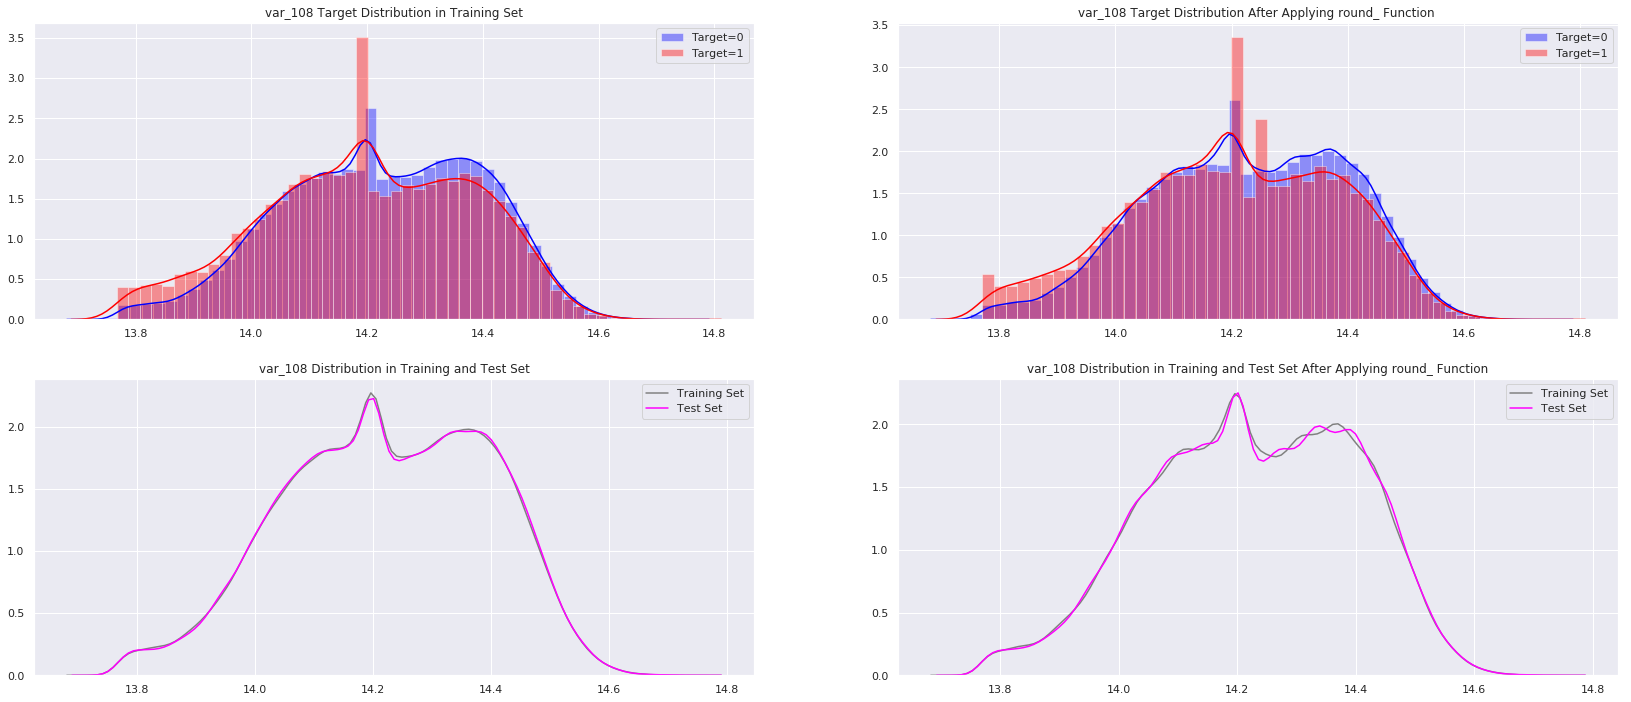

In [24]:
transform_feature(df=df_train, feature='var_108', transformation=np.round, decimals=2)

## **3. Model**

### **3.1 LightGBM**

In [25]:
gbdt_param = {
    # Core Parameters
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 15,
    'tree_learner': 'serial',
    'num_threads': 8,
    'seed': SEED,
    
    # Learning Control Parameters
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 10,  
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'feature_fraction': 0.05,
    'lambda_l1': 1.,
    'bagging_seed': SEED,
    
    # Others
    'verbosity ': 1,
    'boost_from_average': False,
    'metric': 'auc',
}

In [26]:
predictors = df_train.columns.tolist()[2:]
X_test = df_test[predictors]

n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [27]:
for fold, (train_ind, val_ind) in enumerate(skf.split(df_train, df_train.target.values)):
    
    X_train, y_train = df_train.iloc[train_ind][predictors], df_train.iloc[train_ind]['target']
    X_valid, y_valid = df_train.iloc[val_ind][predictors], df_train.iloc[val_ind]['target']

    N = 1
    p_valid, yp = 0, 0
        
    for i in range(N):
        print('\nFold {} - N {}'.format(fold + 1, i + 1))
        
        X_t, y_t = augment(X_train.values, y_train.values)
        weights = np.array([0.8] * X_t.shape[0])
        weights[:X_train.shape[0]] = 1.0
        print('Shape of X_train after augment: {}\nShape of y_train after augment: {}'.format(X_t.shape, y_t.shape))
        
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t, weight=weights)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        
        lgb_clf = lgb.train(gbdt_param, trn_data, 100000, valid_sets=[trn_data, val_data], early_stopping_rounds=5000, verbose_eval=1000, evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof['predict'][val_ind] = p_valid / N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold + 1)] = yp / N



Fold 1 - N 1
Shape of X_train after augment: (336076, 1000)
Shape of y_train after augment: (336076,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.959775	valid_1's auc: 0.883442
[2000]	training's auc: 0.96906	valid_1's auc: 0.901776
[3000]	training's auc: 0.974021	valid_1's auc: 0.910895
[4000]	training's auc: 0.977196	valid_1's auc: 0.915732
[5000]	training's auc: 0.979468	valid_1's auc: 0.918634
[6000]	training's auc: 0.981321	valid_1's auc: 0.920216
[7000]	training's auc: 0.982948	valid_1's auc: 0.921071
[8000]	training's auc: 0.984445	valid_1's auc: 0.921606
[9000]	training's auc: 0.985853	valid_1's auc: 0.921946
[10000]	training's auc: 0.987173	valid_1's auc: 0.922141
[11000]	training's auc: 0.988386	valid_1's auc: 0.922235
[12000]	training's auc: 0.989528	valid_1's auc: 0.922179
[13000]	training's auc: 0.990586	valid_1's auc: 0.922092
[14000]	training's auc: 0.991604	valid_1's auc: 0.922054
[15000]	training's auc: 0.992506	valid_1's au

### **3.2 ROC-AUC Score**

In [28]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])

print('Mean AUC: {}, std: {}.\nAll AUC: {}.'.format(mean_auc, std_auc, all_auc))

Mean AUC: 0.9233290312994764, std: 0.0027892500479293016.
All AUC: 0.9232750016962553.


### **3.3 Feature Importance**

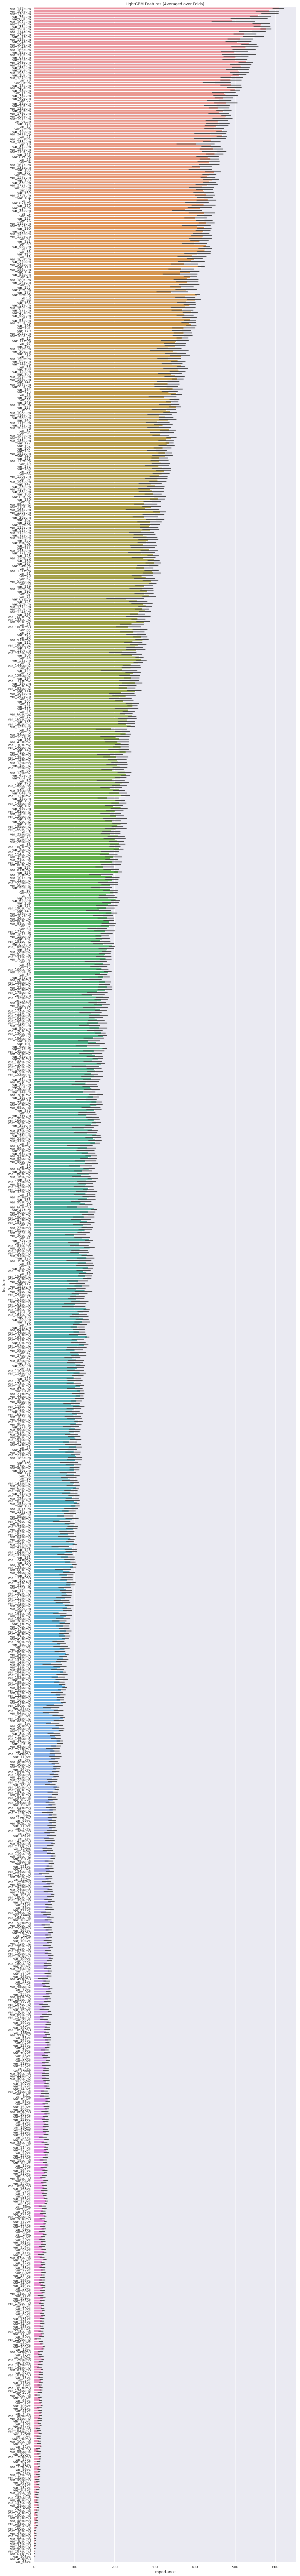

In [29]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(15, 150))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (Averaged over Folds)')
plt.show()

### **3.4 Submission**

In [30]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)